## Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import scipy as sc
import os
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import QuantileRegressor
from sklearn.metrics import mean_absolute_error
import sklearn
import glob
import pathlib as pl

In [2]:
hr_eigs = np.array( pd.read_csv('/ocean/arandhawa/MOAD/analysis-armaan/notebooks/eigvecs_hrdps_annual.csv', header = None) )
hr_PCs = np.array( pd.read_csv('/ocean/arandhawa/MOAD/analysis-armaan/notebooks/PCs_hrdps_annual.csv', header = None) )
hr_data = np.array( pd.read_csv('/ocean/arandhawa/MOAD/analysis-armaan/notebooks/raw_data_3h.csv', header = None) )
print(hr_PCs.shape)
print(hr_eigs.shape)

(136192, 50)
(50, 2904)


In [3]:
psl_eigs = np.array( pd.read_csv('/ocean/arandhawa/MOAD/analysis-armaan/notebooks/eigvecs_psl.csv', header = None) )
psl_PCs = np.array( pd.read_csv('/ocean/arandhawa/MOAD/analysis-armaan/notebooks/PCs_psl.csv', header = None) )
psl_data = np.array( pd.read_csv('/ocean/arandhawa/MOAD/analysis-armaan/notebooks/raw_data_psl.csv', header = None) )
print(psl_PCs.shape)
print(psl_eigs.shape)

(625, 50)
(50, 2904)


In [4]:
cw_eigs = np.array( pd.read_csv('/ocean/arandhawa/MOAD/analysis-armaan/notebooks/eigvecs_winds.csv', header = None) )
cw_PCs = np.array( pd.read_csv('/ocean/arandhawa/MOAD/analysis-armaan/notebooks/PCs_winds.csv', header = None) )
cw_data = np.array( pd.read_csv('/ocean/arandhawa/MOAD/analysis-armaan/notebooks/raw_data_winds.csv', header = None) )
print(cw_PCs.shape)
print(cw_eigs.shape)

(1250, 30)
(30, 2904)


In [5]:
##data must be converted into a 2D matrix for pca analysis
##transform takes a 3D data array (time, a, b) -> (a*b, time)
##(the data grid is flattened a column using numpy.flatten)

def transform(xarr):
    arr = np.array(xarr) ##converting to numpy array
    arr = arr.reshape(arr.shape[0], arr.shape[1]*arr.shape[2]) ##reshaping from size (a, b, c) to (a, b*c)
    arr = arr.transpose()
    return arr

def reverse(mat, orig_shape):
    arr = np.copy(mat)
    arr = arr.transpose()
    arr = arr.reshape(orig_shape[0], orig_shape[1], orig_shape[2]) ##reshaping back to original array shape
    return arr

In [7]:
comb_eigs = np.empty((50, 2904))
for i in range(25):
    comb_eigs[2*i] = cw_eigs[i]
    comb_eigs[2*i + 1] = psl_eigs[i]

In [18]:
def get_scores(num_scores, eigvecs, arr, row):  
    scores = np.empty(num_scores)
    for i in range(num_scores):
        vec = eigvecs[0 : i+1 , :].T
        reg = QuantileRegressor(quantile = 0.5, alpha = 0, solver = 'highs').fit(vec, arr[row,:])
        scores[i] = reg.score(vec, arr[row,:])
    return scores

In [22]:
def get_scores2(num_scores, eigvecs, arr, row):  
    scores = np.empty(num_scores)
    for i in range(num_scores):
        vec = eigvecs[0 : i+1 , :].T
        reg = QuantileRegressor(quantile = 0.5, alpha = 0, solver = 'highs').fit(vec, arr[row,:])
        result = reg.predict(vec)
        scores[i] =  mean_absolute_error(arr[i], result)
    return scores

/home/arandhawa/conda_envs/analysis-armaan/lib/python3.10/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
Status is 4: Numerical difficulties encountered.
Result message of linprog:
An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
  warnings.warn(
/home/arandhawa/conda_envs/analysis-armaan/lib/python3.10/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
Status is 4: Numerical difficulties encountered.
Result message of linprog:
An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
  warnings.warn(
/home/arandhawa/conda_envs/analysis-armaan/lib/python3.10/site-packages/skle

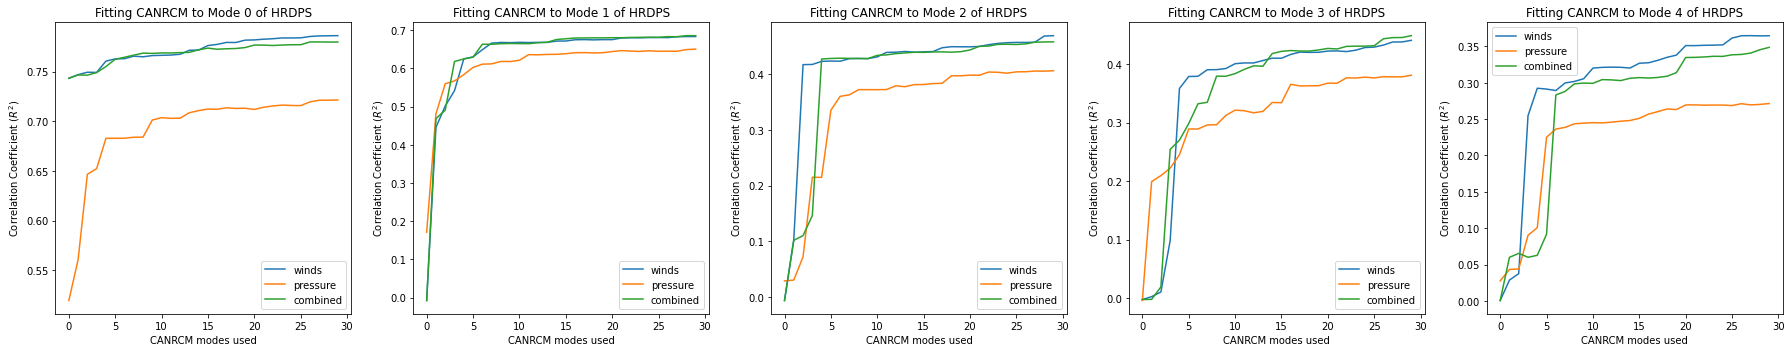

In [24]:
n = 5
fig, ax = plt.subplots(1, n, figsize=(5*n, 5))

for i in range(n):
    ax[i].plot(get_scores(30, cw_eigs, hr_eigs, i), label = "winds")
    ax[i].plot(get_scores(30, psl_eigs, hr_eigs, i), label = "pressure")
    ax[i].plot(get_scores(30, comb_eigs, hr_eigs, i), label = "combined")
    ax[i].set_title("Fitting CANRCM to Mode {} of HRDPS".format(i))
    ax[i].set_xlabel("CANRCM modes used")
    ax[i].set_ylabel("Correlation Coefficient ($R^2$)")
    ax[i].legend()
    
plt.tight_layout()

/home/arandhawa/conda_envs/analysis-armaan/lib/python3.10/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
Status is 4: Numerical difficulties encountered.
Result message of linprog:
An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
  warnings.warn(
/home/arandhawa/conda_envs/analysis-armaan/lib/python3.10/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
Status is 4: Numerical difficulties encountered.
Result message of linprog:
An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
  warnings.warn(
/home/arandhawa/conda_envs/analysis-armaan/lib/python3.10/site-packages/skle

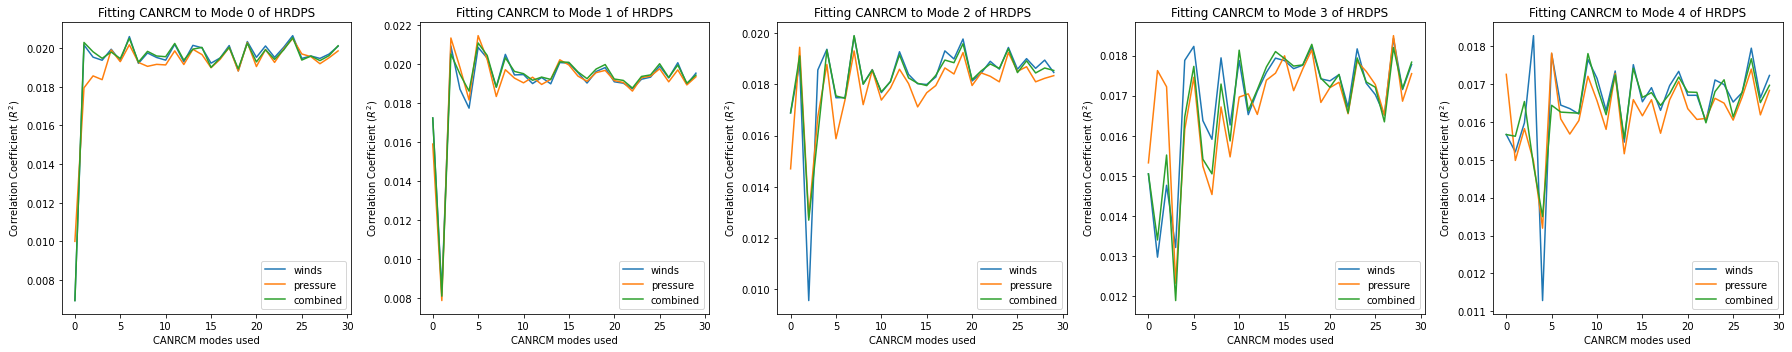

In [23]:
n = 5
fig, ax = plt.subplots(1, n, figsize=(5*n, 5))

for i in range(n):
    ax[i].plot(get_scores2(30, cw_eigs, hr_eigs, i), label = "winds")
    ax[i].plot(get_scores2(30, psl_eigs, hr_eigs, i), label = "pressure")
    ax[i].plot(get_scores2(30, comb_eigs, hr_eigs, i), label = "combined")
    ax[i].set_title("Fitting CANRCM to Mode {} of HRDPS".format(i))
    ax[i].set_xlabel("CANRCM modes used")
    ax[i].set_ylabel("Correlation Coefficient ($R^2$)")
    ax[i].legend()
    
plt.tight_layout()

(2904, 1) (2904,)
0.010002301707789662


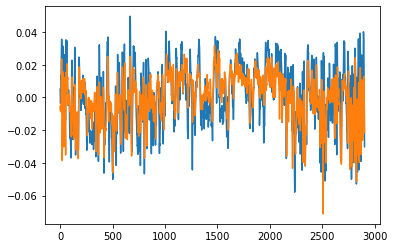

In [10]:
##testing quantile regressor - regresses by minimizing absolute error rather than squared error
X = psl_eigs[0:1,:].T
y = hr_eigs[0]
print(X.shape, y.shape)

reg = QuantileRegressor(quantile = 0.5, alpha = 0, solver = 'highs').fit(X, y)
result = reg.predict(X)

r_squared = reg.score(X, y)
MAE = mean_absolute_error(y, result)
print(MAE)
plt.plot(hr_eigs[0])
plt.plot(result)

In [11]:
def fit_modes(vectors, num_vec, data, result_size):  
    result = np.empty((result_size, vectors.shape[1]))
    scores = np.empty(result_size)
    X = vectors[0:num_vec,:].T
        
    for i in range(result_size):
        y = data[i,:]
        reg = QuantileRegressor(quantile = 0.5, alpha = 0, solver = 'highs').fit(X, y)
        result[i] = reg.predict(X)
        scores[i] = reg.score(X, y)

    return (result, scores)

1.121250952834454
1.1519578622184738
1.3661163332417396
1.5849499108257321
1.85108212088503


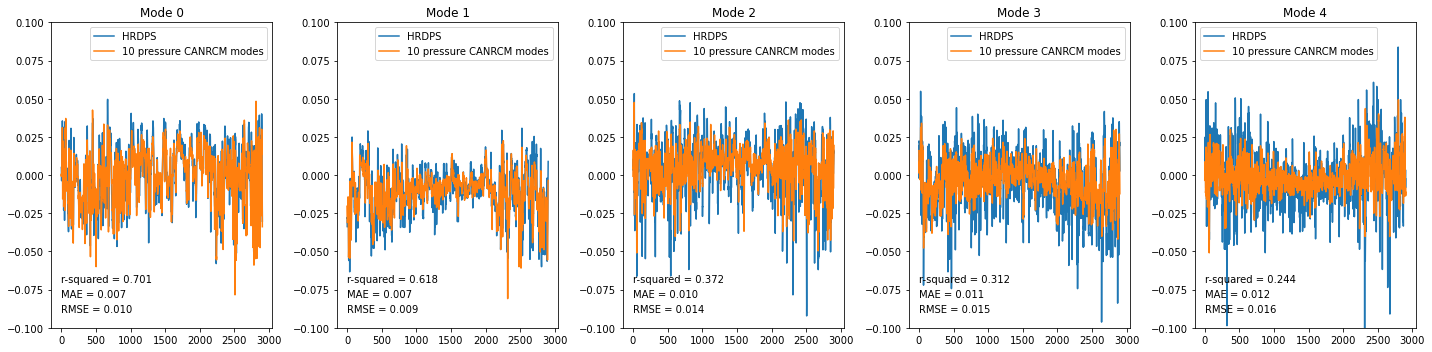

In [15]:
n = 10
new_eigs, scores = fit_modes(psl_eigs, n, hr_eigs, 5)

fig, ax = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    
    MAE = mean_absolute_error(hr_eigs[i], new_eigs[i])
    rmse = np.sqrt( sklearn.metrics.mean_squared_error(hr_eigs[i], new_eigs[i]) )
    r_squared = scores[i]
    
    ax[i].plot(hr_eigs[i], label = "HRDPS")
    ax[i].plot(new_eigs[i], label = "{} pressure CANRCM modes".format(n))
    ax[i].set_ylim(-0.1, 0.1)
    ax[i].annotate("r-squared = {:.3f}".format(r_squared), (0, -0.07))
    ax[i].annotate("MAE = {:.3f}".format(MAE), (0, -0.08))
    ax[i].annotate("RMSE = {:.3f}".format(rmse), (0, -0.09))
    ax[i].set_title("Mode {}".format(i))
    ax[i].legend()
    
    print(np.sqrt( np.mean(hr_eigs[i]**2) / np.mean(new_eigs[i]**2) ))
plt.tight_layout()

1.1093726996269184
1.13123692923076
1.3085006505539862
1.4572142760193887
1.671410790634212


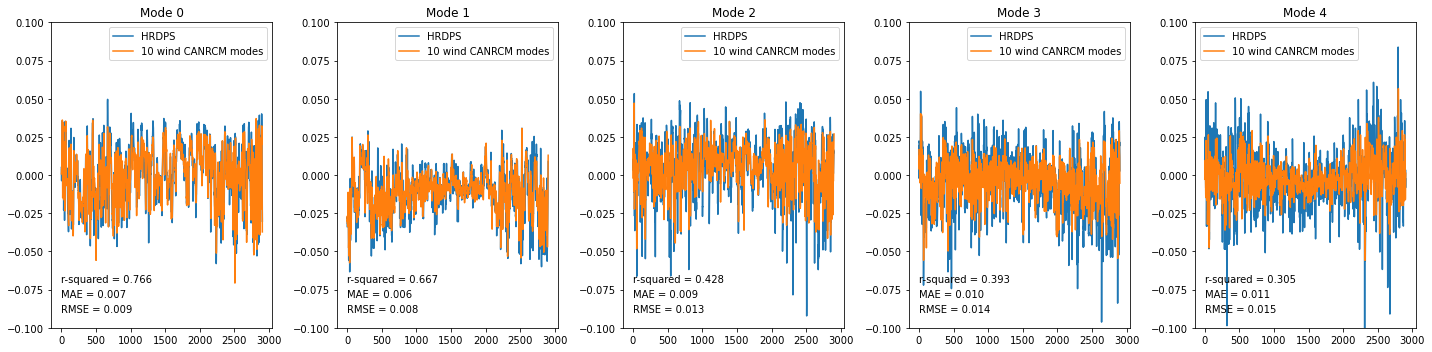

In [26]:
n = 10
new_eigs2, scores = fit_modes(cw_eigs, n, hr_eigs, 5)

fig, ax = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    
    MAE = mean_absolute_error(hr_eigs[i], new_eigs[i])
    rmse = np.sqrt( sklearn.metrics.mean_squared_error(hr_eigs[i], new_eigs[i]) )
    r_squared = scores[i]
    
    ax[i].plot(hr_eigs[i], label = "HRDPS")
    ax[i].plot(new_eigs[i], label = "{} wind CANRCM modes".format(n))
    ax[i].set_ylim(-0.1, 0.1)
    ax[i].annotate("r-squared = {:.3f}".format(r_squared), (0, -0.07))
    ax[i].annotate("MAE = {:.3f}".format(MAE), (0, -0.08))
    ax[i].annotate("RMSE = {:.3f}".format(rmse), (0, -0.09))
    ax[i].set_title("Mode {}".format(i))
    ax[i].legend()
    
    print(np.sqrt( np.mean(hr_eigs[i]**2) / np.mean(new_eigs[i]**2) ))
plt.tight_layout()

/home/arandhawa/conda_envs/analysis-armaan/lib/python3.10/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
Status is 4: Numerical difficulties encountered.
Result message of linprog:
An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
  warnings.warn(


1.1108993487753016
1.110649130839116
1.3070682183482885
1.452852722542807
1.6497595927802755


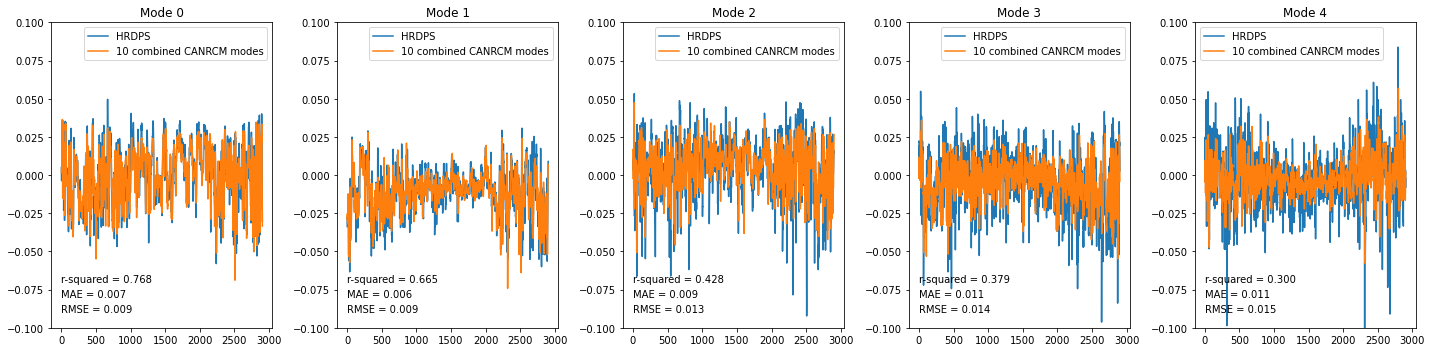

In [17]:
n = 10
new_eigs, scores = fit_modes(comb_eigs, n, hr_eigs, 5)

fig, ax = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    
    MAE = mean_absolute_error(hr_eigs[i], new_eigs[i])
    rmse = np.sqrt( sklearn.metrics.mean_squared_error(hr_eigs[i], new_eigs[i]) )
    r_squared = scores[i]
    
    ax[i].plot(hr_eigs[i], label = "HRDPS")
    ax[i].plot(new_eigs[i], label = "{} combined CANRCM modes".format(n))
    ax[i].set_ylim(-0.1, 0.1)
    ax[i].annotate("r-squared = {:.3f}".format(r_squared), (0, -0.07))
    ax[i].annotate("MAE = {:.3f}".format(MAE), (0, -0.08))
    ax[i].annotate("RMSE = {:.3f}".format(rmse), (0, -0.09))
    ax[i].set_title("Mode {}".format(i))
    ax[i].legend()
    
    print(np.sqrt( np.mean(hr_eigs[i]**2) / np.mean(new_eigs[i]**2) ))
plt.tight_layout()

## Conserving Energy

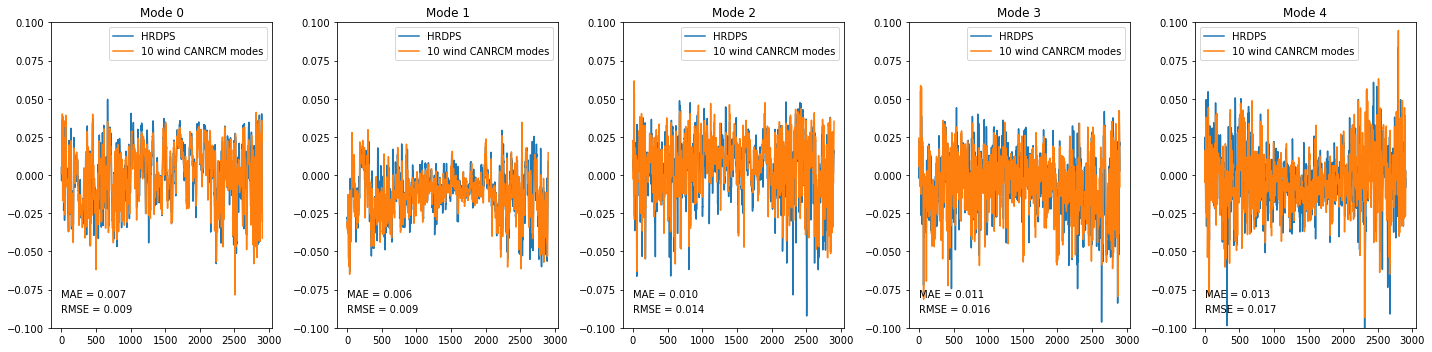

In [29]:
new_eigs, scores = fit_modes(cw_eigs, 10, hr_eigs, 5)

fig, ax = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    
    f = np.sqrt( np.mean(hr_eigs[i]**2) / np.mean(new_eigs[i]**2) )
    new_eigs[i] = new_eigs[i]*f
    
    MAE = mean_absolute_error(hr_eigs[i], new_eigs[i])
    rmse = np.sqrt( sklearn.metrics.mean_squared_error(hr_eigs[i], new_eigs[i]) )
    ##correlation_matrix = np.corrcoef(x, y)
    ##r_squared = correlation_matrix[0,1]**2
    ##r_squared = scores[i]
    ax[i].plot(hr_eigs[i], label = "HRDPS")
    ax[i].plot(new_eigs[i], label = "10 wind CANRCM modes")
    ax[i].set_ylim(-0.1, 0.1)
    ##ax[i].annotate("r-squared = {:.3f}".format(r_squared), (0, -0.07))
    ax[i].annotate("MAE = {:.3f}".format(MAE), (0, -0.08))
    ax[i].annotate("RMSE = {:.3f}".format(rmse), (0, -0.09))
    ax[i].set_title("Mode {}".format(i))
    ax[i].legend()
    
plt.tight_layout()

In [31]:
def equalize_energy(eigs, old_eigs):
    new_eigs = np.sqrt( (old_eigs[0:eigs.shape[0]]**2).mean(axis = 1)/(eigs**2).mean(axis = 1))* eigs.T
    return new_eigs.T

## Exports

In [35]:
new_eigs, _ = fit_modes(cw_eigs, 20, hr_eigs, 20)
new_eigs2 = equalize_energy(new_eigs, hr_eigs)

In [33]:
new_eigs2.shape

(10, 2904)

In [36]:
np.savetxt("eigvecs_recon.csv", new_eigs2, delimiter=",")

In [ ]:
##MAE (duplicate notebook)
##test different #'s of modes

In [ ]:

##compare total energy, for each new mode when reconstructed from 10, 20, and 30 modes
##do the dot plots from last notebook
